# Ejercicio Practico 3
## Regresión Logística

Continuando con el mismo conjunto de datos de los anteriores temás vistos hasta ahora, en esta práctica vamos a tratar de modelizar con un modelo de regresión logística una de las variables en función del resto de variables.

El objetivo de esta práctica es entender la utilidad y la metodología a seguir para construir y validar un modelo de regresión logística, que permita clasificar los registros de nuestro conjunto de datos entre las 2 clases de una variable dicotómica.

### 1. Preparación de los datos

En primer lugar vamos a importar las librerías de python que serán necesarias para realizar el analisis y el conjunto de datos limpio y preparado de los temas anteriores:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from scipy.stats import boxcox, shapiro, chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, RegressorMixin
from relativeImp import relativeImp
from itertools import combinations
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)
from sklearn.utils import resample

In [2]:
# Configuración que permite mostrar todas las filas y columnas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Cargar el dataset desde el archivo CSV
data = pd.read_csv('vehicles_prep.csv')

A continuación, como hicimos en la regresión lineal, vamos convertir a tipo *int* las variables dummy que al hacer la carga hayan sido transformadas en booleanas.

In [3]:
# Convertir booleanos a numéricos
boolean_columns = data.select_dtypes(include='bool').columns
data[boolean_columns] = data[boolean_columns].astype(int)

# Asegurar que los datos son numéricos
data = data.apply(pd.to_numeric, errors='coerce')

In [4]:
# Mostrar info acerca del dataframe y las primeras filas
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406029 entries, 0 to 406028
Columns: 142 entries, price to state_wy
dtypes: float64(3), int64(139)
memory usage: 439.9 MB


,price,year,odometer,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_chrysler,manufacturer_datsun,manufacturer_dodge,manufacturer_ferrari,manufacturer_fiat,manufacturer_ford,manufacturer_gmc,manufacturer_harley-davidson,manufacturer_honda,manufacturer_hyundai,manufacturer_infiniti,manufacturer_jaguar,manufacturer_jeep,manufacturer_kia,manufacturer_land rover,manufacturer_lexus,manufacturer_lincoln,manufacturer_mazda,manufacturer_mercedes-benz,manufacturer_mercury,manufacturer_mini,manufacturer_mitsubishi,manufacturer_morgan,manufacturer_nissan,manufacturer_pontiac,manufacturer_porsche,manufacturer_ram,manufacturer_rover,manufacturer_saturn,manufacturer_subaru,manufacturer_tesla,manufacturer_toyota,manufacturer_volkswagen,manufacturer_volvo,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,cylinders_12 cylinders,cylinders_3 cylinders,cylinders_4 cylinders,cylinders_5 cylinders,cylinders_6 cylinders,cylinders_8 cylinders,cylinders_other,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,title_status_lien,title_status_missing,title_status_parts only,title_status_rebuilt,title_status_salvage,transmission_manual,transmission_other,drive_fwd,drive_rwd,type_bus,type_convertible,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon,paint_color_blue,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow,state_al,state_ar,state_az,state_ca,state_co,state_ct,state_dc,state_de,state_fl,state_ga,state_hi,state_ia,state_id,state_il,state_in,state_ks,state_ky,state_la,state_ma,state_md,state_me,state_mi,state_mn,state_mo,state_ms,state_mt,state_nc,state_nd,state_ne,state_nh,state_nj,state_nm,state_nv,state_ny,state_oh,state_ok,state_or,state_pa,state_ri,state_sc,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
0,1.123740,0.294846,-0.536952,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.366721,-0.238402,-0.322616,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.536659,1.094718,-1.161354,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.944808,0.694782,-0.807553,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-0.155622,0.161534,0.591863,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Como primer paso, vamos a preparar la variable objetivo. En este caso, nuestra variable objetivo va a ser el tipo de tracción del coche (***drive***). Si recordamos de los ejercicios anteriores, esta variable categórica podía tomar 3 posibles valores: fwd (tracción delantera), rwd (tracción trasera) y 4wd (tracción a las 4 ruedas). En este ejercicio de regresión logística vamos a clasificar una variable categórica con 2 únicas categorías que podamos asociar con 0 o 1. Como esta variable tiene 3 categorías, vamos a eliminar los registros de una de ellas para adaptarla a lo que necesitamos. Para hacer esta elección, nos sacamos el volumen de registros de cada categoría. Como tenemos el dataset adaptado con variables dummy para los ejercicios anteriores, tendremos que trabajarlo un poco más para obtener esta información.

In [5]:
# Variables dummy asociadas a 2 de las 3 categorías
dummys_drive = ['drive_fwd', 'drive_rwd']

# Creamos un dataframe para almacenar los conteos y porcentajes de cada variable
counts_drive = pd.DataFrame(columns=['Variable', 'Count','Percentage'])

for var in dummys_drive:
    # Obtener los conteos y los porcentajes
    value_counts = data[var].value_counts()
    percentages = data[var].value_counts(normalize=True) * 100
    
    # Crear un DataFrame con los conteos y los porcentajes
    counts_drive.loc[len(counts_drive)] = {'Variable': var, 'Count': value_counts[1], 'Percentage': percentages[1]}

# Añadir la cuenta y porcentajes de la categoría que falta
count_missing = len(data) - counts_drive['Count'].sum()
perc_missing = 100*count_missing/len(data)
counts_drive.loc[len(counts_drive)] = {'Variable': 'drive_4wd', 'Count': count_missing, 'Percentage': perc_missing}

# Mostrar el DataFrame
counts_drive

,Variable,Count,Percentage
0,drive_fwd,143311,35.295755
1,drive_rwd,71669,17.651202
2,drive_4wd,191049,47.053043


En vista de los números obtenidos, vamos a eliminar todos los registros asociados a la variable ***drive_rwd***, es decir, todos los vehículos con ese tipo de transmisión. De esta forma nos quedamos únicamente con 2 posibles categorías en cuanto al tipo de transmisión (fwd y 4wd) y que además están bastante balanceadas entre ellas. Este balance entre ambas nos facilita el analisis ya que no tenemos que balancear el dataset para obtener un modelo más robusto a la hora de predecir la categoría minoritaria.

Además de los registros donde la variable ***drive_rwd*** era igual a 1, eliminamos también la variable dummy asociada ya que no aporta valor al ser todo 0s.

In [6]:
# Filtrar filas donde transmission_other sea distinto de 1
data = data[data['drive_rwd'] != 1]

# Eliminar la columna de la categoría eliminada
data = data.drop(columns='drive_rwd')

Recalculamos de nuevo los porcentajes y número de registros para ver la ponta que tiene nuestra nueva variable objetivo. Importante notar que aunque solo tenemos una variable en el conjunto que hace referencia en este caso a la tracción *fwd* (***drive_fwd***), cuando ésta es 0, significa que la transmisión es de la ota categoría (*4wd*), por lo que con solo una tenemos toda la información. La variable la vamos a mantener llamandose ***drive_fwd*** ya que para nosotros y para el modelo de regresión logística que vamos a crear, nuestra variable objetivo es 1 cuando se da un suceso (que el vehículo tenga tracción delantera fwd) y es 0 cuando no es así.

In [7]:
# Obtener los conteos y los porcentajes
value_counts = data['drive_fwd'].value_counts()
percentages = data['drive_fwd'].value_counts(normalize=True) * 100

# Crear un DataFrame con los conteos y los porcentajes
result = pd.DataFrame({'Count': value_counts, 'Percentage': percentages})

# Mostrar el DataFrame
result

,Count,Percentage
drive_fwd,,
0,191049,57.138713
1,143311,42.861287


Seguimos con el ejercicio y vamos a proceder a separar nuestro conjunto de datos en 2 dataframes, uno con la variable objetivo únicamente (***y***) y otro con todas las variables predictoras (***X***). Dividimos a conitnuación, cada uno de estos 2 conjuntos en 2 conjuntos a su vez: Uno de entrenamiento y otro para validación o test.

In [8]:
# Separar variables predictoras y objetivo
X = data.drop(columns='drive_fwd')
y = data['drive_fwd']

In [9]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Ahora vamos a adentrarnos en el mundo de la regresión logística de lleno y vamos a ir con todo a probar a entrenar un modelo de este tipo con estos datos. Como siempre, para usar la librería de statsmodel, añadimos manualmente el el termino independiente al conjunto de entrenamiento y acto seguido, creamos y ajustamos el modelo de regresión logística mostrando los resultados devueltos.

In [10]:
# Añadir una constante para el término independiente
X_train_const = sm.add_constant(X_train)

# Crear y ajustar el modelo
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit(maxiter=100)

# Resumen completo
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.206834
         Iterations 19


LinAlgError: Singular matrix

Como se puede ver en la ejecución del modelo, no es capaz de completarse el entrenamiento dado que se acaba encontrando con una matriz singular. Esto se traduce en un problema seguramente de multicolinealidad debido a fuerte dependencia lineal entre alguna de las variables. Esta dependencia lineal hace que la matriz no se pueda invertir y por tanto no se pueden obtener los coeficientes de la regresión.

Era demasiado bonito para ser cierto que, metiendo todo en la cocketelera como si no hubiera hecho falta casi hacer una fase de entendimiento y preparación de los datos, hubieramos dado a la primera con el modelo perfecto.

Vamos a hacer una segunda prueba con un subconjunto de las variables. Vamos a eliminar las variables ***state***, ***transmission***, ***cylinders***, ***manufacturer***, ***type*** y ***fuel*** con todas sus dummies, y a continuación volvemos a separar crear los conjuntos separados y de entrenamiento y valdidación.

In [11]:
# Lista de prefijos a eliminar
prefixes_to_remove = ['state', 'transmission', 'cylinders', 'manufacturer', 'type', 'fuel']

# Filtrar columnas cuyo nombre empieza con alguno de los prefijos
columns_to_remove = [col for col in data.columns if any(col.startswith(prefix) for prefix in prefixes_to_remove)]

# Agregar una columna específica que también deseas eliminar
columns_to_remove.append('drive_fwd')

# Separar variables predictoras y objetivo
X = data.drop(columns=columns_to_remove)
y = data['drive_fwd']

In [12]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
# Añadir una constante para el término independiente
X_train_const = sm.add_constant(X_train)

# Crear y ajustar el modelo
logit_model = sm.Logit(y_train, X_train_const).fit(maxiter=100)

# Resumen completo
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.606424
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              drive_fwd   No. Observations:               267488
Model:                          Logit   Df Residuals:                   267463
Method:                           MLE   Df Model:                           24
Date:                Fri, 10 Jan 2025   Pseudo R-squ.:                  0.1120
Time:                        00:15:09   Log-Likelihood:            -1.6221e+05
converged:                       True   LL-Null:                   -1.8267e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.6844      0.010    -68.433      0.000      -0.704   

Esto ya es otra cosa. El modelo ha convergido siendo capaz de estimar los coeficientes de la regresión en tan solo 6 iteraciones. Puede que no sea el mejor modelo pero al menos tenemos un modelo.

Si analizamos los resultados del entrenamiento podemos ver como primeros parametros el número de observaciones, los grados de libertad de los residuos y del modelo. El número de observaciones no es más el que número de registros del conjunto de entrenamiento. Los grados de libertad del modelo es el número de variables predictoras, es decir, el número de coeficientes ha estimar (sin contar con el intercepto). Y por último los grados de libertad de los residuos (n - k), es la cantidad de datos que dispone el modelo para poder explicar la variabilidad residual del modelo, es decir lo que el modelo no capaz de explicar.

Más adelante podemos ver la métrica Log-Likelihood (el logaritmo de la verosimilitud) y LL-NULL (logaritmo de la verosimilitud del modelo nulo). Ambos son valores negativos muy grandes, dificiles de interpretar por si solos. Al final el hecho de que sean valores muy altos o muy pequeños, en parte depende de que tengamos un conjunto de datos con más o menos registros. Lo que si que vemos es que es mayor el Log-Likelihood que el LL-NULL. Esto ya nos indica que nuestro modelo es mejor que el modelo nulo. Luego tenemos el valor LLR p-value que no es más que el p-value del test de hipotesis que pretende determinar si la diferencia entre nuestro modelo y el modelo nulo es significativa o no. Es decir, si realmente es más alta la verosimilitud de nuestro modelo en una medida suficiente como para asegurar que es mejor que el modelo nulo. En este caso, sale 0, por lo que rechazamos la hipotesis nula de que son estadisticamente iguales ambos modelos.

La métrica Pseudo-R2, es una forma de analizar todos los parametros anteriores de en un solo valor y determinar si realmente nuestro modelo es bueno. En este caso nos sale un valor de 0.112. En un modelo de regresión lineal con este valor de R2 diriamos que es malo, pero en regresión logística, el Pseudo-R2 se mueve en valores buenos entre 0.2 y 0.4 y por tanto un valor de 0.112 no es tan malo. Se puede decir que es capaz de explicar un 11.2% más sobre la variable objetivo que el modelo nulo.

En cuanto a los coeficientes, podemos ver que no hay valores desorbitados de error estandar en ninguno que nos llame la atencion. Los p-value, hay alguno por encima de 0.05 lo que puede indicar que pueda no ser significativamente distinto de 0.

Vamos a pasar a calcular los odds de los coeficientes para interpretarlos.

In [14]:
# Obtener los coeficientes
coefficients = logit_model.params

# Calcular los odds ratios aplicando exp a los coeficientes
odds_ratios = np.exp(coefficients)

# Crear un DataFrame con las dos columnas: coeficientes y odds ratios
tab_coefs_odds = pd.DataFrame({
    'Coeficientes': coefficients,
    'Odds Ratios': odds_ratios
})

# Mostrar la tabla
tab_coefs_odds.sort_values(by='Coeficientes',ascending=False)

,Coeficientes,Odds Ratios
condition_good,0.571360,1.770673
paint_color_purple,0.361994,1.436191
year,0.337301,1.401161
paint_color_silver,0.293869,1.341608
condition_fair,0.259838,1.296721
paint_color_custom,0.247656,1.281019
condition_like new,0.208731,1.232113
paint_color_grey,0.197590,1.218462
paint_color_blue,0.177485,1.194210
paint_color_red,0.176179,1.192651


Al analizar los odds, podemos interpretar por ejemplo que variables como ***condition_good*** hacen que cuando el registro es de esta categoría, los odds respecto de cuando no tiene esta condición, aumentan en un factor 1.77. Esto hace que la probalidad de que la tracción sea delantera sea mayor. Es decir, que el hecho de que el coche esté en buenas condiciones está más relacionado con el hecho de que el vehículo sea de tracción delantera más que de tracción a las 4 ruedas.

en el otro extremo de la tabla tenemos el precio, que para un aumento de un punto en la variable de ***price***, los odds respecto de la situación de partida, decaen al 34% de su valor, por lo que la probabilidad de que el vehículo sea de tracción delantera también decae en esa proporción. Esto es indicativo de que cuanto mayor sea el precio, seguramente más probable es que el vehículo sea un 4x4.

Vamos ahora a anlizar las los valores predichos en el conjunto de entrenamiento para ver que tal clasifica nuestro modelo según otras métricas.

In [15]:
# Hacer predicciones (probabilidad de clase 1)
y_proba = logit_model.predict(X_train_const)

# Convertir las probabilidades en predicciones binarias
threshold = 0.5
y_pred = (y_proba >= threshold).astype(int)

# Construir la matriz de confusión
cm = confusion_matrix(y_train, y_pred)

# Evaluación del modelo
print("Matriz de confusión:")
print(cm)

# Convertir la matriz de confusión a porcentajes
cm_percentage = cm.astype('float') / cm.sum() * 100

# Imprimir la matriz en porcentajes con formato legible
print("Matriz de confusión en porcentajes:")
print(np.round(cm_percentage, 2))

Matriz de confusión:
[[117691  35148]
 [ 55395  59254]]
Matriz de confusión en porcentajes:
[[44.   13.14]
 [20.71 22.15]]


En primer lugar vamos a analizar la matriz de confusión. En los resultados se muestra tanto en valor absoluto el número de registros como en porcentajes. Si vemos los porcentajes, vemos que el volumen de falsos negativos es de un 20%, tenemos un volumen muy elevado de este tipo de errores. Del mismo modo, los falsos positivos suponen un 13% que tampoco es desdeñable. En conclusión, no parece que nuestro modelo esté captando bien la variabilidad de la variable objetivo. Parece que tiene un problema de sesgo importante.

Seguimos analizando métricas del conjunto entrenado. Vamos a calcular los ratios a partir de la matriz de confusión.

In [16]:
print("\nReporte de clasificación:")
print(classification_report(y_train, y_pred))


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.68      0.77      0.72    152839
           1       0.63      0.52      0.57    114649

    accuracy                           0.66    267488
   macro avg       0.65      0.64      0.64    267488
weighted avg       0.66      0.66      0.66    267488



A la vista de estos resultados podemos ver lo siguiente. A nivel general, el modelo es capaz de acertar en el 66% de los casos. Claramente es mejor que el modelo nulo que acertará aproximadamente la mitad de las veces. Sin embargo no es que sea un valor para tirar cohetes.

La sensibilidad (recall) del modelo a la clase 0 es de un 77% que significa que, de los registros reales de clase 0, acierta en el 77% de ellos. Sin embargo, cuando clasifica la clase 1, acierta solo el 52% de los valores reales de clase 1. Nuestro modelo tiene una tendencia mayor a clasificar hacia clase 1 que hacia la 0, y por ello suele acertar en mayor proporción los valores reales de la clase 0 que en la 1. Si en nuestro caso fuera vital acertar los registros de clase 0, nuestro modelo podría ser más útil ya que se comporta mejor hacía esa clase.

Por otro lado tenemos la métrica de precisión nos da una idea de la tasa de aciertos cuando el modelo dice que la clase es de un tipo. Este valor es del 63% para la clase 1 y del 68% para la clase 0. No son valores del todo malos.

Por último tenemos el f1-score que de alguna forma armoniza para cada clase la precisión y la sensibilidad. En este caso, como hay cierto sesgo hacía la clase 1, el modelo tiene un f1-score más alto (72%) que cuando la clase es 0 (57%).

Vamos a visualizar ahora la curva ROC y el area bajo ella. Recordemos que seguimos con el conjunto de entrenamiento.


AUC-ROC: 0.729


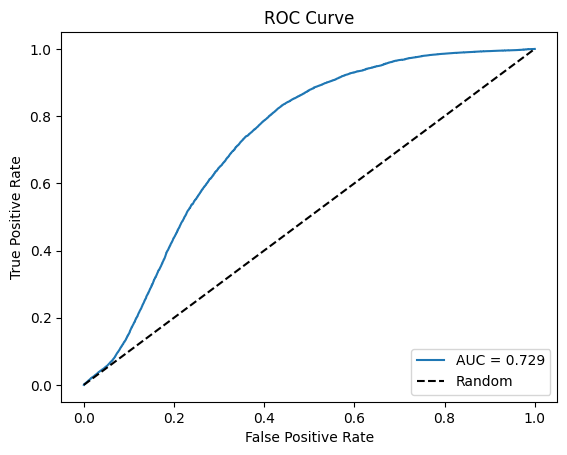

In [17]:
# Métrica AUC-ROC
auc = roc_auc_score(y_train, y_proba)
print(f"\nAUC-ROC: {auc:.3f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_train, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Por la pinta que tiene la curva, claramente el modelo que hemos creado clasifica mejor que un modelo aleatorio. El area bajo la curva de este modelo, 0.729, es mejor que el 0.5 del modelo aleatorio pero tampoco es la bomba. Es un modelo razonable o decente.

Vamos a mostrar en un gráfico de densidad las probabilidades predichas por el modelo en el conjunto de entrenamiento.

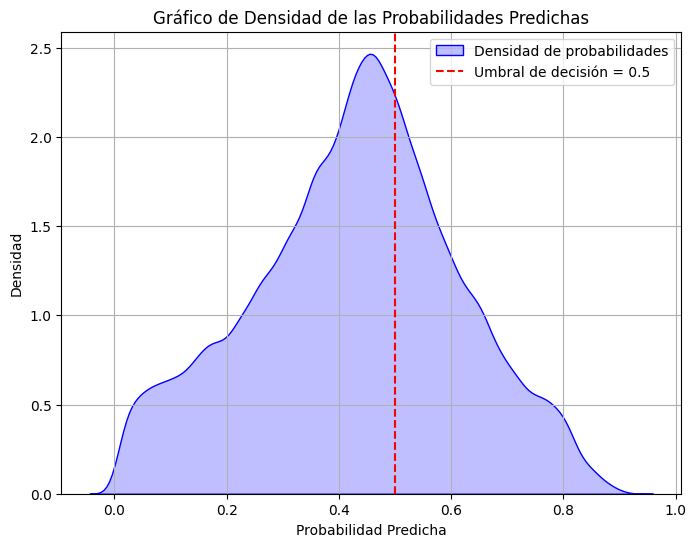

In [18]:
plt.figure(figsize=(8, 6))
sns.kdeplot(y_proba, fill=True, color="blue", label="Densidad de probabilidades")
plt.title('Gráfico de Densidad de las Probabilidades Predichas')
plt.xlabel('Probabilidad Predicha')
plt.ylabel('Densidad')
plt.axvline(x=0.5, color='red', linestyle='--', label="Umbral de decisión = 0.5")
plt.legend()
plt.grid(True)
plt.show()

A la vista del gráfico lo primero que vemos es que las probabilidades que ha estimado nuestro modelo son bastante ambigüas en general. Es decir, que casi siempre el modelo estima probabilidades entre 0.4 y 0.6 con un máximo en 0.45 aproximadamente. Es dificil que un modelo así sea capaz de discernir claramente entre lo que es una clase 0 y una clase 1. La probabilidad de error es alta. Es cierto que las colas de esta distribución parece que son valores alejados del centro y por lo tanto el modelo distingue fácilmente si el registro es de clase 0 o 1.

Como ejercicio didactico, vamos a modificar de forma exagerada el umbral de decisión situandolo en 0.2 y vemos como cambian estos resultados.

In [19]:
# Hacer predicciones (probabilidad de clase 1)
y_proba = logit_model.predict(X_train_const)

# Convertir las probabilidades en predicciones binarias
threshold = 0.2
y_pred = (y_proba >= threshold).astype(int)

# Construir la matriz de confusión
cm = confusion_matrix(y_train, y_pred)

# Evaluación del modelo
print("Matriz de confusión:")
print(cm)

# Convertir la matriz de confusión a porcentajes
cm_percentage = cm.astype('float') / cm.sum() * 100

# Imprimir la matriz en porcentajes con formato legible
print("Matriz de confusión en porcentajes:")
print(np.round(cm_percentage, 2))

Matriz de confusión:
[[ 32715 120124]
 [  1797 112852]]
Matriz de confusión en porcentajes:
[[12.23 44.91]
 [ 0.67 42.19]]


En la matriz de confusión, este cambio ha impactado claramente en la cantidad de falsos negativos pasando de un 20% a un 0.6%. Al desplazar el umbral a la zona más cercana a la clase 0, lo que hacemos es que solo clasificamos como 0 aquellos registros cuya probabilidad es menor que 0.2, es decir, los más cercanos a 0, los que con más seguridad son 0. En ellos, fallar es muy dificil y por eso baja tanto la cantidad de falsos negativos. Por extensión, la cantidad de verdaderos negativos sube mucho pasando de 22% a 42% ya que ahora clasificamos casi todo como clase 1  por tanto, ahí no fallamos. En cuanto a los positivos, los verdaderos positivos bajan de 44% a 12% ya que parece que en esa franja entre 0.5 y 0.2, había muchos registros que son realmente 0 y ahora los estamos clasificando como 1. Los falsos positivos también suben bastante, basicamente todos los que han salido de los verdaderos positivos, han pasado a falsos positivos. Del mismo modo que los falsos negativos han pasado todos a los verdaderos negativos.

In [20]:
print("\nReporte de clasificación:")
print(classification_report(y_train, y_pred))


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.95      0.21      0.35    152839
           1       0.48      0.98      0.65    114649

    accuracy                           0.54    267488
   macro avg       0.72      0.60      0.50    267488
weighted avg       0.75      0.54      0.48    267488



Las métricas confirman lo mismo que la matriz: La sensibilidad se desbalancea mucho en favor de la clase 1 ya que ahora tenemos el umbral muy cercano a 0 y casi todo se clasifica como 1, es decir, de todos los valores reales 1, casi todos los acertamos ya que la mayoría entran en el rango de probabilidad entre 0.2 y 1. Sin embargo, pasa lo contrario con los valores reales de 0. Ahora clasificamos como 0 solo aquellos de los que estamos muy muy seguros, asique nos dejamos muchos 0 reales por el camino.

La precisión tambien se desbalancea, los 0 que dice nuestro modelo son casi todos 0 reales (95%), mientras que los 1 que dice nuestro modelo, ahora solo el 48% de ellos son 1 realmente.

Por ultimo, la exactitud (accuracy) global baja ya que en general nuestro modelo falla más que antes.


AUC-ROC: 0.729


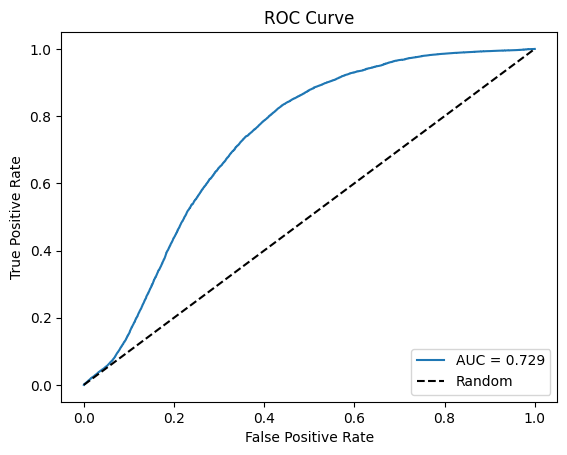

In [21]:
# Métrica AUC-ROC
auc = roc_auc_score(y_train, y_proba)
print(f"\nAUC-ROC: {auc:.3f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_train, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

La curva ROC sigue siendo la misma. Esto se debe a que la construcción de la curva ROC pasa por todos los posibles umbrales desde 0 hasta 1, por lo que lleva implicitos todos y por tanto no está sujeto a un cambio concreto. Al final cada punto de esta curva te da, para un umbral concreto, el valor de la tasa de falsos positivos y la de verdaderos positivos. Esta curva es una forma de ver como cambian esas 2 tasas según evoluciona el umbral de decisión desde 0 hasta 1.

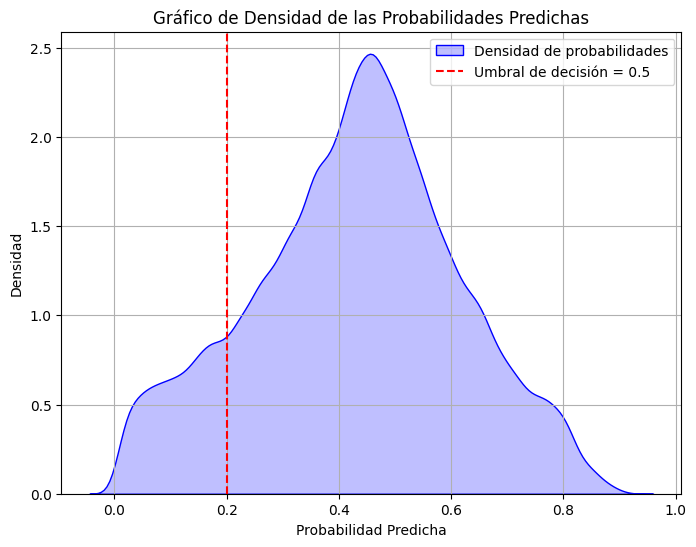

In [23]:
plt.figure(figsize=(8, 6))
sns.kdeplot(y_proba, fill=True, color="blue", label="Densidad de probabilidades")
plt.title('Gráfico de Densidad de las Probabilidades Predichas')
plt.xlabel('Probabilidad Predicha')
plt.ylabel('Densidad')
plt.axvline(x=0.2, color='red', linestyle='--', label="Umbral de decisión = 0.5")
plt.legend()
plt.grid(True)
plt.show()

Ahora vamos a comparar los resultados de las métricas del primer modelo en el conjunto de entrenamiento con las del conjunto de validación para ver que tal generaliza con datos que nunca ha visto.

In [24]:
# Añadir una constante para el término independiente
X_test_const = sm.add_constant(X_test)

# Hacer predicciones (probabilidad de clase 1)
y_proba = logit_model.predict(X_test_const)

# Convertir las probabilidades en predicciones binarias
threshold = 0.5
y_pred = (y_proba >= threshold).astype(int)

# Construir la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Evaluación del modelo
print("Matriz de confusión:")
print(cm)

# Convertir la matriz de confusión a porcentajes
cm_percentage = cm.astype('float') / cm.sum() * 100

# Imprimir la matriz en porcentajes con formato legible
print("Matriz de confusión en porcentajes:")
print(np.round(cm_percentage, 2))

Matriz de confusión:
[[29460  8750]
 [13912 14750]]
Matriz de confusión en porcentajes:
[[44.05 13.08]
 [20.8  22.06]]


En este caso, los valores absolutos que obtenemos son, como es lógico, inferiores en general puesto que estamos entrenando con una muestra. Sin embargo, los porcentajes son prácticamente iguales. Esto quiere decir que el modelo, aunque con cierto grado de sesgo, generaliza muy bien, es decir, su varianza es muy baja o casi nula.

In [25]:
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.68      0.77      0.72     38210
           1       0.63      0.51      0.57     28662

    accuracy                           0.66     66872
   macro avg       0.65      0.64      0.64     66872
weighted avg       0.66      0.66      0.66     66872



Las métricas de clasificación son por tanto iguales también ya que están basadas en la matriz de confusión que ya hemos visto que son proporcionalmente iguales.


AUC-ROC: 0.730


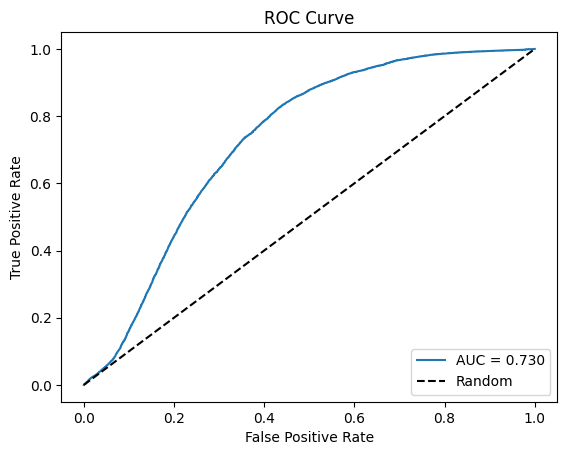

In [26]:
# Métrica AUC-ROC
auc = roc_auc_score(y_test, y_proba)
print(f"\nAUC-ROC: {auc:.3f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

La curva ROC es casi identica y el area bajo la curva, para este conjunto con el que hemos entrenado, es el mismo.

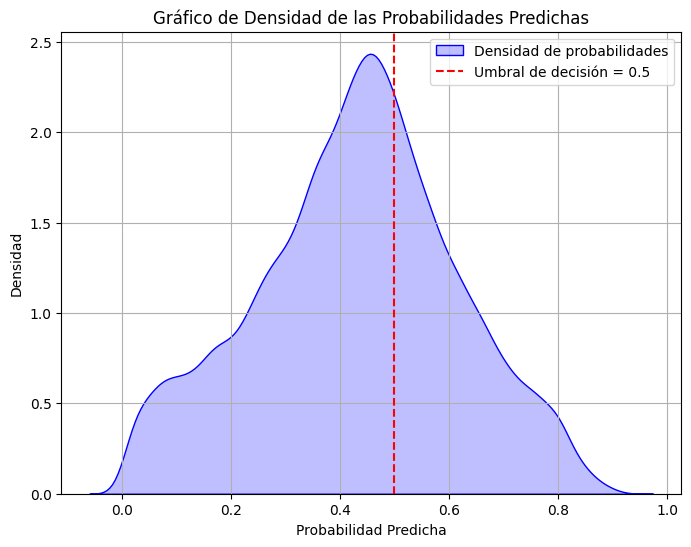

In [27]:
plt.figure(figsize=(8, 6))
sns.kdeplot(y_proba, fill=True, color="blue", label="Densidad de probabilidades")
plt.title('Gráfico de Densidad de las Probabilidades Predichas')
plt.xlabel('Probabilidad Predicha')
plt.ylabel('Densidad')
plt.axvline(x=0.5, color='red', linestyle='--', label="Umbral de decisión = 0.5")
plt.legend()
plt.grid(True)
plt.show()

La gráfica es de nuevo igual que la anterior, es decir que las probabilidades estimadas por el modelo se distribuyen exactamente igual en el conjunto de entrenamiento que en el de test. En este punto, parece razonable un umbral de 0.5 generico para la decisión de clasificación. Quizá un valor más adecuado podría ser la moda de esta distribución, o la media o mediana. También se podría estimar en base a la curva ROC el punto más cercano al punto (1,0). De este analisis si que es cierto que una de las posibles razones que nos permitan entender porqué el modelo acierta ligeneramente mejor la clase 1 que la 0, es debido a que el umbra está situado en un punto en el que el area hacia el lado derecho (hacia la clase 1) es menor que el 50%. Esto puede llevar a que estemos reduciendo el margen de error que hay para esta clase ya que estamos siendo ligeramente más conservadores.

Si por ejemplo cambiamos el valor del umbral situandolo en 0.45, la matriz de confusión quedaría así:

In [28]:
# Añadir una constante para el término independiente
X_test_const = sm.add_constant(X_test)

# Hacer predicciones (probabilidad de clase 1)
y_proba = logit_model.predict(X_test_const)

# Convertir las probabilidades en predicciones binarias
threshold = 0.45
y_pred = (y_proba >= threshold).astype(int)

# Construir la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Evaluación del modelo
print("Matriz de confusión:")
print(cm)

# Convertir la matriz de confusión a porcentajes
cm_percentage = cm.astype('float') / cm.sum() * 100

# Imprimir la matriz en porcentajes con formato legible
print("Matriz de confusión en porcentajes:")
print(np.round(cm_percentage, 2))

Matriz de confusión:
[[26003 12207]
 [ 9279 19383]]
Matriz de confusión en porcentajes:
[[38.88 18.25]
 [13.88 28.99]]


Hemos aumentado el porcentaje de falsos positivos a 18% (el modelo predice 1 para un valor real de 0) y han disminuido los falsos negativos al 14%. Lás metricas quedan así:

In [29]:
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.74      0.68      0.71     38210
           1       0.61      0.68      0.64     28662

    accuracy                           0.68     66872
   macro avg       0.68      0.68      0.68     66872
weighted avg       0.68      0.68      0.68     66872



Se puede ver como todas las métricas se han igualado más y el modelo a nivel general tiene una mayor exactitud (accuracy) que antes. La sensibilidad se ha igualado para ambas clases, lo cual cuadra con el hecho de que hemos situado el umbral en un punto más central de la distribución siendo ésta más o menos simétrica.

In [30]:
# Calcular el área hacia la derecha del umbral de 0.5
area_right = np.sum(y_proba > 0.5) / len(y_proba)
print(f"El área hacia la derecha del umbral 0.5 es: {area_right:.4f}")

# Calcular el área hacia la derecha del umbral de 0.45
area_right = np.sum(y_proba > 0.45) / len(y_proba)
print(f"El área hacia la derecha del umbral 0.45 es: {area_right:.4f}")

El área hacia la derecha del umbral 0.5 es: 0.3514
El área hacia la derecha del umbral 0.45 es: 0.4724


Al calcular el area hacia la derecha del umbral se ve claramente que con el umbral de 0.45 estamos mucho más cercanos al 50% de la distribución que antes que habíamos situado el umbral para un 35% de area hacía la derecha.

En cuanto a la precisión, se han separado más los valores. La precisión de la clase 0 ha aumentado ya que le hemos movido el umbral ligeramente hacia dicha clase y por ello es más preciso el modelo cuando clasifica 0 que antes. Le hemos quitado margen de error. Sin embargo la clase 1, empeora ya que le hemos dado aun más margen de error.

Ahora vamos intentar mejorar nuestro modelo de regresión logística y para ello vamos a hacer una selección distinta de las variables escogidas. Está claro que todas las variables no las podemos poner puesto que se genera dependencia lineal y el modelo ni siquiera converge, pero quizá haya otras variables más apropiadas que aporten más información al modelo para explicar la variabilidad de la variable objetivo.

Para hacer esta selección vamos a empezar reconstruyendo las variables categóricas originales ya que, en el dataset actual, las tenemos convertidas a variables dummies y es mucho más cómodo analizar las relaciones con la variable objetivo cuando son categóricas a través de la V de Cramer.

In [31]:
# Reconstruir las variables categóricas originales
def reverse_one_hot_encoding(df, column_prefixes):
    recovered_columns = {}
    for prefix in column_prefixes:
        # Filtrar columnas que corresponden al prefijo
        cols = [col for col in df.columns if col.startswith(prefix + '_')]
        
        # Extraer nombres de categorías de las columnas
        categories = [col.split('_', 1)[1] for col in cols]
        
        # Crear una nueva columna categórica
        recovered_columns[prefix] = np.select(
            condlist=[df[col] == 1 for col in cols],
            choicelist=categories,
            default='missing'  # Categoría eliminada
        )
    
    return pd.DataFrame(recovered_columns)

# Definir los prefijos de las variables originales
column_prefixes = ['state', 'paint_color','type','drive','transmission','title_status','fuel','cylinders','condition','manufacturer']

# Aplicar la función para reconstruir las variables categóricas originales
recovered_data = reverse_one_hot_encoding(data, column_prefixes)

# Resultado
print("\nDataset recuperado:")
recovered_data.head()


Dataset recuperado:


,state,paint_color,type,drive,transmission,title_status,fuel,cylinders,condition,manufacturer
0,al,color_white,pickup,missing,other,missing,gas,8 cylinders,good,gmc
1,al,color_blue,pickup,missing,other,missing,gas,8 cylinders,good,chevrolet
2,al,color_red,pickup,missing,other,missing,gas,8 cylinders,good,chevrolet
3,al,color_red,pickup,fwd,other,missing,gas,8 cylinders,good,toyota
4,al,missing,pickup,missing,other,missing,gas,8 cylinders,good,gmc


Una vez reconstruidas, lo que hacemos es calcular la matriz de coeficientes de V de Cramer para ver como se relacionan unas con otras.

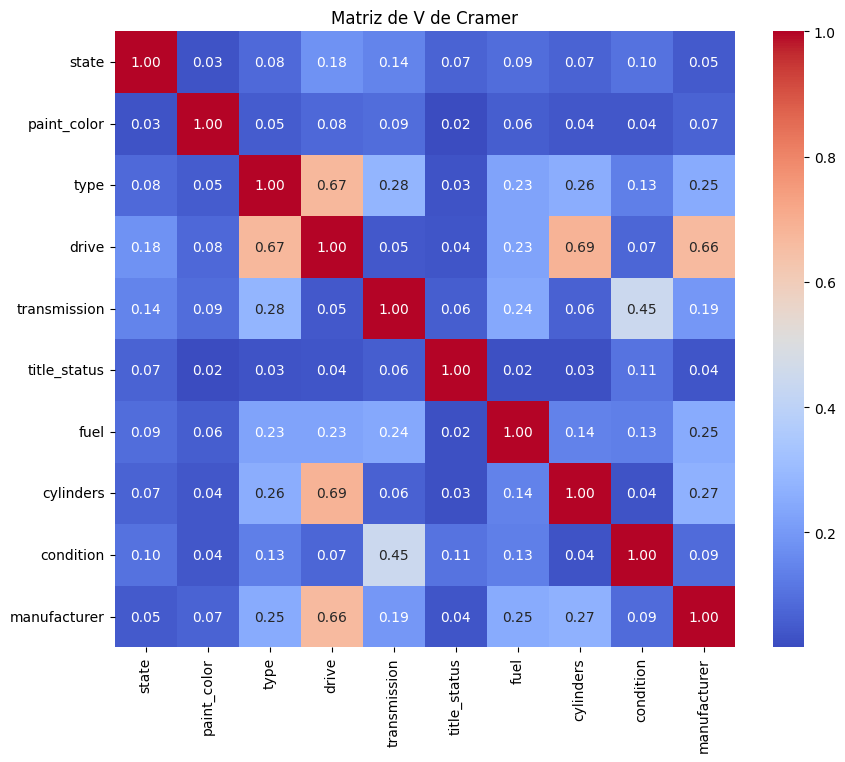

In [32]:
# Función para calcular V de Cramér
def cramers_v(confusion_matrix):
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()  # Número total de observaciones
    k = min(confusion_matrix.shape)  # Número de categorías en la variable
    return np.sqrt(chi2 / (n * (k - 1)))

# Identificar las variables categóricas
category_columns = recovered_data.select_dtypes(include=['object', 'category']).columns

# Crear una matriz vacía para almacenar los valores de V de Cramer
matrix = pd.DataFrame(index=category_columns, columns=category_columns)

# Calcular V de Cramer para cada par de variables categóricas
for var1, var2 in combinations(category_columns, 2):
    contingency_table = pd.crosstab(recovered_data[var1], recovered_data[var2])
    value = cramers_v(contingency_table)
    matrix.loc[var1, var2] = value
    matrix.loc[var2, var1] = value

# Llenar la diagonal con 1s
np.fill_diagonal(matrix.values, 1)

# Convertir a tipo float
matrix = matrix.astype(float)

# Visualizar la matriz como heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de V de Cramer")
plt.show()

Para empezar, vamos a fijarnos en la variable ***drive*** que es nuestra variable objetivo. De entre las variables categóricas, vemos que hay algunas que tienen cierta relación con esta variable. Las que más relación tienen son ***type*** con 0.67, ***cylinders*** con 0.69 y ***manufacturer*** con 0.66. Luego, con menos relación pero que algo aportan, tenemos ***state*** con 0.18 y ***fuel*** con 0.23. Las demás variables no parecen tener ninguna relación con nuestra variable objetivo.

Si analizamos las relaciones entre las variables que más tienen relación con la objetivo entre si, vemos que por ejemplo ***type*** no tiene relación fuerte con ninguna, ***cylinders*** tampoco parece tener ninguna relación relevante, ***manufacturer***, ***fuel*** y ***state*** tampoco. Esto es importante porque seguramente no estaremos generando multicolinealidad al incluirlas en el modelo. Si que es cierto que luego al codificarlas en dummies, si que se pueden generar dependencias lineales dentro de ellas entre categorías, pero al menos sabemos que entre las variables no parece que hay peligro.

Vamos a analizar a ver como son las relaciones entre la obetivo y las variables numéricas.

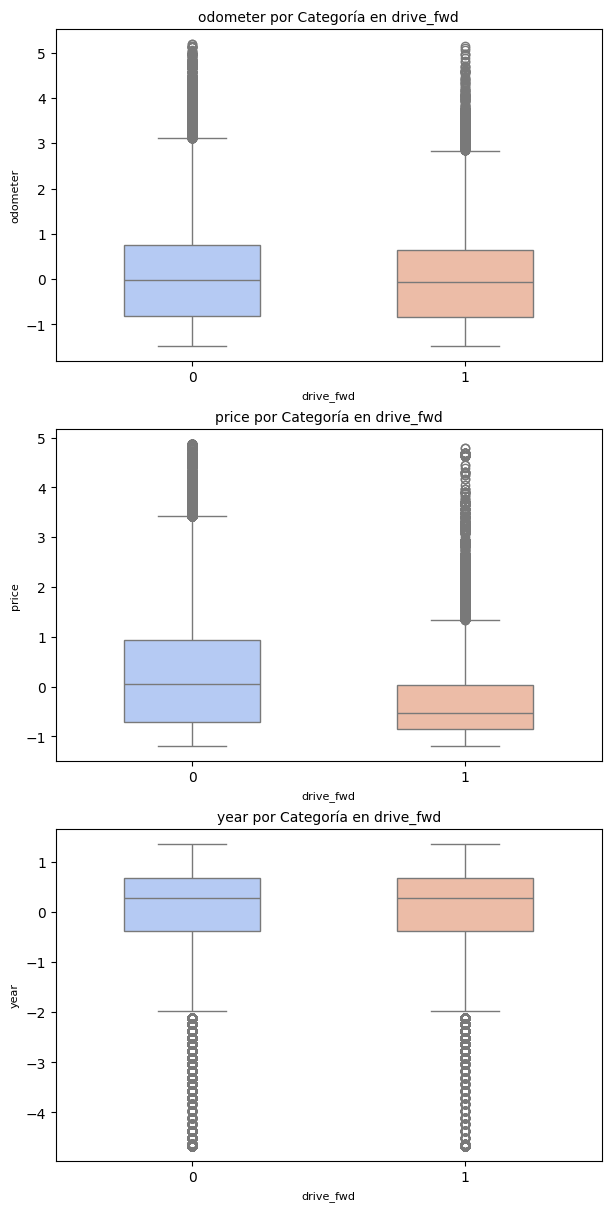

In [33]:
target_var = 'drive_fwd'

# Identificar las columnas numéricas
numeric_columns = ['odometer','price','year']

# Crear el grid de subplots
n_vars = len(numeric_columns)
fig, axes = plt.subplots(n_vars, 1, figsize=(6, 4 * n_vars), constrained_layout=True)

# Generar un boxplot por cada variable numerica
for ax, var in zip(axes, numeric_columns):
    # Ordenar las categorías según la mediana calculada
    medians = data.groupby(target_var)[var].median().sort_values(ascending=False)
    ordered_categories = medians.index
    
    # Generar el boxplot con las categorías ordenadas
    sns.boxplot(x=target_var, y=var, data=data, order=ordered_categories, palette='coolwarm', hue=target_var, legend=False, ax=ax, width=0.5)
    ax.set_title(f'{var} por Categoría en {target_var}', fontsize=10)
    ax.set_xlabel(target_var, fontsize=8)
    ax.set_ylabel(var, fontsize=8)

# Mostrar el grid de boxplots
plt.show()

Aparentemente, solo la variable ***price*** parece tener algo de relación con la variable objetivo ***drive***. Parece que cuando es tracción delantera *fwd*, el precio suele ser más bajo que cuando es tracción a las 4 ruedas. Por tanto tiene sentido que solo nos quedemos con la variable ***price*** de entre las numéricas. Además, en la matriz de correlación que se muestra a continuación, se puede ver que entre si, tienen bastante relación las 3 por lo que con la variable ***price*** capturamos parte de la poca información que aportan las otras 2 sobre ***drive***.

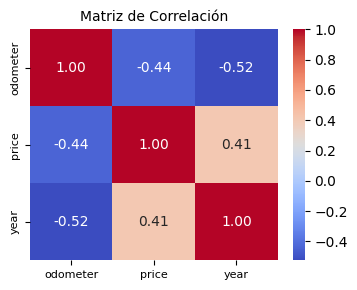

In [34]:
# Correlación entre variables numéricas
correlation_matrix = data[['odometer', 'price', 'year']].corr()

plt.figure(figsize=(4, 3))

# Dibujar la matriz de correlación como un heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, annot_kws={"size": 10})
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title("Matriz de Correlación", fontsize=10)
plt.show()

Pasamos por tanto a diseñar un modelo nuevo de regresión logística con solo algunas de las variables: ***price***, ***cylinders***, ***fuel*** y ***type***. Estas son algunas de las que más relación parecían tener con la variable objetivo. Dividimos el nuevo conjunto de datos en los habituales.

In [35]:
# Lista de prefijos a eliminar
prefixes_to_remove = ['state', 'paint_color', 'transmission', 'title_status', 'condition', 'manufacturer', 'odometer', 'year']

# Filtrar columnas cuyo nombre empieza con alguno de los prefijos
columns_to_remove = [col for col in data.columns if any(col.startswith(prefix) for prefix in prefixes_to_remove)]

# Agregar una columna específica que también deseas eliminar
columns_to_remove.append('drive_fwd')

# Separar variables predictoras y objetivo
X = data.drop(columns=columns_to_remove)
y = data['drive_fwd']

In [36]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Y entrenamos el modelo...

In [37]:
# Añadir una constante para el término independiente
X_train_const = sm.add_constant(X_train)

# Crear y ajustar el modelo
logit_model = sm.Logit(y_train, X_train_const).fit(maxiter=100)

# Resumen completo
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.310828
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              drive_fwd   No. Observations:               267488
Model:                          Logit   Df Residuals:                   267463
Method:                           MLE   Df Model:                           24
Date:                Fri, 10 Jan 2025   Pseudo R-squ.:                  0.5449
Time:                        00:39:59   Log-Likelihood:                -83143.
converged:                       True   LL-Null:                   -1.8267e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -6.6748      0.284    -23.507      0.000      -7.231      

Para empezar, el modelo ha convergido en tan solo 8 iteraciones, lo que es buena señal. Por otro lado, viendo directamente el Pseudo-R2, vemos que ha subido mucho a 0.545, que es un valor muy muy bueno para una regresión lineal. Esto significa que este modelo explica un 55% más sobre la variable objetivo que lo que lo hace el modelo nulo.

El Log-Likelihood ha subido muy significativamente estando ya en valores varios órdenes de maginitud más arriba que el del modelo nulo. Los coeficientes tienen todos por su parte, el p-value igual a 0, por lo que son todos estadisticamente significativos y ninguno presenta un error estandar desproporcionado.

En resumen, se trata de un modelo muy muy bueno, ideal para clasificar esta variable ***drive***.

Veamos ahora los odds asociados a los coeficientes:

In [38]:
# Obtener los coeficientes
coefficients = logit_model.params

# Calcular los odds ratios aplicando exp a los coeficientes
odds_ratios = np.exp(coefficients)

# Crear un DataFrame con las dos columnas: coeficientes y odds ratios
tab_coefs_odds = pd.DataFrame({
    'Coeficientes': coefficients,
    'Odds Ratios': odds_ratios
})

# Mostrar la tabla
tab_coefs_odds.sort_values(by='Coeficientes',ascending=False)

,Coeficientes,Odds Ratios
cylinders_4 cylinders,5.501082,244.956810
type_mini-van,5.071433,159.402538
cylinders_12 cylinders,4.864379,129.590471
cylinders_3 cylinders,4.650205,104.606392
cylinders_5 cylinders,4.321110,75.272149
cylinders_other,4.108860,60.877305
type_van,3.536681,34.352728
type_sedan,2.819583,16.769863
cylinders_6 cylinders,2.599247,13.453597
fuel_hybrid,2.162982,8.697035


En este caso las variables son distintas y los coeficientes tambien. Por ejemplo, la variable ***cylinders_4 cylinders*** se destaca como la que parece ser la variable con mayor relación con la clase 1 de la variable obejtivo. Parece que los vehículos que tienen 4 cilindros, tienden a ser todos de tracción delantera *fwd*. Lo mismo ocurre con los de 12, 3 y 5, al igual que los vehículos que son tipo mini-van, van o sedan.

En el otro lado de la tabla, tenemos los vehículos tipo offroad especialmente y los tipo truck, que claramente son en su mayoría de tracción a las 4 ruedas y por ello acercan las probabilidades de la regresión al 0. Lo mismo que el precio, parece que cuanto mayor es el precio, menor es la probabilidad estimada y por tanto más cercano a la clase 0, es decir, a la clase de los vehículos 4x4.

Pasamos a predecir en el conjunto de validación para ver como generaliza.

In [39]:
# Añadir una constante para el término independiente
X_test_const = sm.add_constant(X_test)

# Hacer predicciones (probabilidad de clase 1)
y_proba = logit_model.predict(X_test_const)

# Convertir las probabilidades en predicciones binarias
threshold = 0.5
y_pred = (y_proba >= threshold).astype(int)

# Construir la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Evaluación del modelo
print("Matriz de confusión:")
print(cm)

Matriz de confusión:
[[33032  5178]
 [ 3342 25320]]


In [40]:
# Convertir la matriz de confusión a porcentajes
cm_percentage = cm.astype('float') / cm.sum() * 100

# Imprimir la matriz en porcentajes con formato legible
print("Matriz de confusión en porcentajes:")
print(np.round(cm_percentage, 2))

Matriz de confusión en porcentajes:
[[49.4   7.74]
 [ 5.   37.86]]


La matriz de confusión muestra un volumen de errores (falsos positivos o negativos) muy bajos, del 5% y el 7,7%.

In [41]:
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.91      0.86      0.89     38210
           1       0.83      0.88      0.86     28662

    accuracy                           0.87     66872
   macro avg       0.87      0.87      0.87     66872
weighted avg       0.87      0.87      0.87     66872



Las métricas nos dicen más o menos lo mismo que la matriz. La exactitud del modelo es muy alta 87% y las demás métricas también. Están bastante balanceadas en general todas ellas por lo que no parece que haya sesgo en favor de ninguna de las 2 clases. El recall (sensibilidad) al estar casi iguales, nos indica que el umbral escogido está situado muy cerca del centro (50 percentil). 

Por otro lado, la precisión, aun siendo muy buenas, la precisión con que el modelo clasifica la clase 0 es mayor que cuando lo hace con la clase 1. Esta pequeña variación puede ser porque tiene mejor cogido el patrón cuando es de clase 0 que el de clase 1.

In [42]:
# Calcular el área hacia la derecha del umbral de 0.5
area_right = np.sum(y_proba > 0.5) / len(y_proba)
print(f"El área hacia la derecha del umbral 0.5 es: {area_right:.4f}")

El área hacia la derecha del umbral 0.5 es: 0.4561



AUC-ROC: 0.935


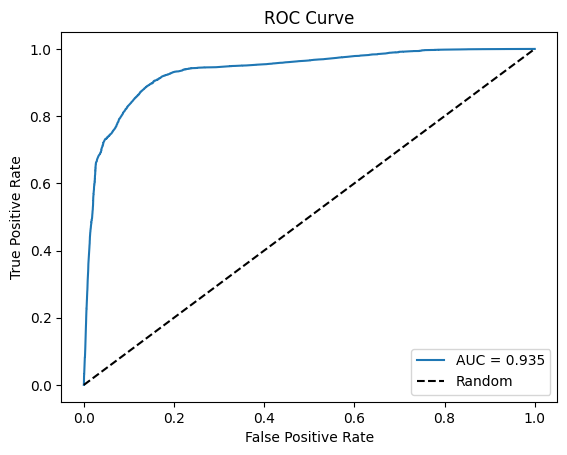

In [43]:
# Métrica AUC-ROC
auc = roc_auc_score(y_test, y_proba)
print(f"\nAUC-ROC: {auc:.3f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

El area bajo la curva ROC está en unos niveles muy muy buenos por encima de 0.93. La forma de la curva ROC también muestra un acercamiento mucho mayor al punto (1,0) por lo que se aleja mucho del modelo aleatorio.

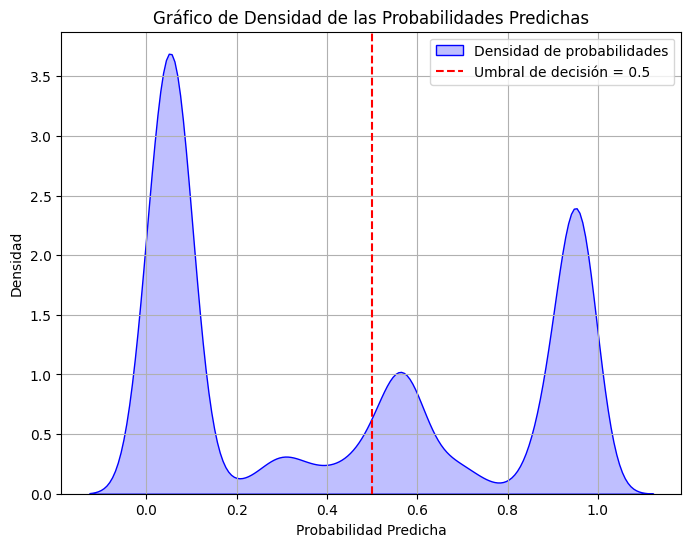

In [44]:
plt.figure(figsize=(8, 6))
sns.kdeplot(y_proba, fill=True, color="blue", label="Densidad de probabilidades")
plt.title('Gráfico de Densidad de las Probabilidades Predichas')
plt.xlabel('Probabilidad Predicha')
plt.ylabel('Densidad')
plt.axvline(x=0.5, color='red', linestyle='--', label="Umbral de decisión = 0.5")
plt.legend()
plt.grid(True)
plt.show()

En cuanto a la grafica de densidad de probabilidad, se ve una distribución muy distinta a la del modelo original. Aquí se distinguen muy claramente valores de probabilidad concentrados en torno al 0 y otro grupo de valores muy concentrados en torno al 1. Al ser tan extremos, la clasificación es muy buena y el umbral se puede poner en un punto más allá o más acá, que realmente no tendría gran impacto porque hasta que llegue al grueso que son esos 2 grupos extremos, no modificaría significativamente la clasificación y, por extensión, las métricas del modelo.

Si que es cierto que hay un tercer grupo con cierta relevancia en torno al punto 0.55 que parece que no tiene muy claro que si clasificar en un sentido o en otro ya que no son probabilidades tan claras como las otras. En este grupo podría haber algun tipo de patrón no detectado y que sus registros podrían ser de cualquiera de las 2 clases, lo que nos podría estar llevando a los pocos errores que hemos visto en las métricas.